### Import Packages

In [1]:
import pandas as pd
import numpy as np

datapath = 'data/'

### Load Data

In [2]:
data = pd.read_csv(datapath + 'disaster_train.csv', sep=',',)

### Transfrom data

we extract the text of the tweets as X vector and the transform them into a `tf-idf` (term-frequency times inverse document-frequency) matrix. 

__TODO__
- At a later stage add location and keyword data to the feature matrix
    - Problem: How do we addjust the weight of those, should they way as much as the occurence of one word or more?
    

In [7]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = data['text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# the function TfidfVectorizer transforms our data in a sparse feature matrix. Every feature is the td-idf of a n-gram. The sizes of the 
# n-grams are set by our argument ngram_range.
# with the argument stopwords we can remove words that typically occur often but do not give any information (i.e. and, a, ...)
tf_computer = TfidfVectorizer(use_idf=False, ngram_range=(1,1), stop_words='english')

train_features = tf_computer.fit_transform(X_train)
test_features = tf_computer.transform(X_test)

print("vocabulary size:", len(tf_computer.vocabulary_))


vocabulary size: 19097


In [8]:
108206/19097

5.666125569461172

# First naive try

In [16]:
# select a linear model based on the assumption that specific words (linearly) imply a real disaster or not

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# TODO: vary hpyerparameter alpha

clf = RidgeClassifier()
scores = cross_val_score(clf, train_features, y_train, cv=3, scoring="f1")
scores

array([0.73647059, 0.7452381 , 0.73079179])

In [10]:
clf.fit(train_features, y_train)
y_train_pred = clf.predict(train_features)
y_test_pred = clf.predict(test_features)


print('Train F1 score:', np.round(f1_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(f1_score(y_test, y_test_pred), 3))

Train F1 score: 0.945
Test F1 score: 0.744


This looks very much like overfitting

# Second (a bit less) naive try
Lets try a neural network.

Get some ideas [here](https://medium.com/@datamonsters/artificial-neural-networks-for-natural-language-processing-part-1-64ca9ebfa3b2)

### Load packages

In [11]:
import tensorflow #the backend used by Keras (there are different beckend)
from tensorflow.keras.models import Sequential #import the type of mpdel: sequential (e.g., MLP)
from tensorflow.keras.layers import Dropout, Input, Dense #simple linear layer
from tensorflow.keras.utils import to_categorical # transformation for classification labels
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
import matplotlib.pyplot as plt

2022-01-05 16:35:44.375932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-05 16:35:44.375961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Create early stopping mechanism for NN

In [12]:
from keras.callbacks import EarlyStopping

# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)

np.random.seed(123)
set_random_seed(2)

In [13]:
train_features_den = train_features.todense()

In [14]:
train_features_den.shape

(6471, 19097)

In [15]:
feature_vector_length = train_features_den.shape[1]

model = Sequential() #we first define how the "model" looks like
model.add(Dense(input_dim = feature_vector_length, units=100 , activation='relu')) #input layer
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax')) #output layer

# Configure the model and start training
model.compile(loss='sparse_categorical_crossentropy', #loss metric
    optimizer='adam',  #optimizer
    metrics=['accuracy']) #displayed metric


history = model.fit(train_features_den, y_train, epochs=10, verbose=2)

2022-01-05 16:36:02.945216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-05 16:36:02.945234: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-05 16:36:02.945246: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (siprius): /proc/driver/nvidia/version does not exist
2022-01-05 16:36:02.945428: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
203/203 - 4s - loss: 0.5269 - accuracy: 0.7373 - 4s/epoch - 18ms/step
Epoch 2/10
203/203 - 3s - loss: 0.2275 - accuracy: 0.9124 - 3s/epoch - 17ms/step
Epoch 3/10
203/203 - 3s - loss: 0.0815 - accuracy: 0.9685 - 3s/epoch - 16ms/step
Epoch 4/10
203/203 - 3s - loss: 0.0430 - accuracy: 0.9839 - 3s/epoch - 16ms/step
Epoch 5/10
203/203 - 3s - loss: 0.0258 - accuracy: 0.9896 - 3s/epoch - 17ms/step
Epoch 6/10
203/203 - 3s - loss: 0.0185 - accuracy: 0.9929 - 3s/epoch - 17ms/step
Epoch 7/10
203/203 - 3s - loss: 0.0143 - accuracy: 0.9946 - 3s/epoch - 16ms/step
Epoch 8/10
203/203 - 3s - loss: 0.0104 - accuracy: 0.9954 - 3s/epoch - 16ms/step
Epoch 9/10
203/203 - 3s - loss: 0.0109 - accuracy: 0.9960 - 3s/epoch - 16ms/step
Epoch 10/10
203/203 - 3s - loss: 0.0094 - accuracy: 0.9958 - 3s/epoch - 16ms/step


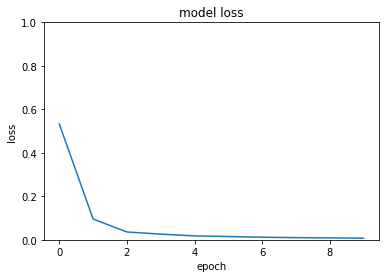

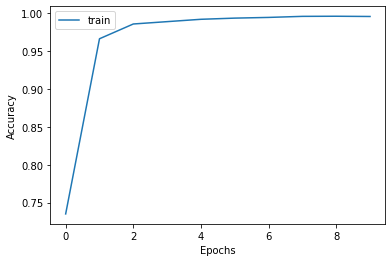

In [104]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [106]:
model.fit(train_features_den, y_train)
y_train_pred = clf.predict(train_features_den)
y_test_pred = clf.predict(test_features.todense())


print('Train F1 score:', np.round(f1_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(f1_score(y_test, y_test_pred), 3))

2022-01-03 17:34:52.733115: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2800804104 exceeds 10% of free system memory.


203/203 [==============================] - 17s 82ms/step - loss: 0.0073 - accuracy: 0.9960


/home/jan/ds/ml/nlp-project/nlp-venv/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jan/ds/ml/nlp-project/nlp-venv/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Train F1 score: 0.985
Test F1 score: 0.727


In [17]:
from sklearn.metrics import accuracy_score

print('Train F1 score:', np.round(accuracy_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(accuracy_score(y_test, y_test_pred), 3))

Train F1 score: 0.954
Test F1 score: 0.79
